In [1]:
import requests
import requests.auth
import json
import numpy as np
from scipy import stats
import seaborn as sns

## Read in ID, API key, Username and Password from separate files

In [2]:
with open('client_id.txt', 'r') as CLIENT_ID: CLIENT_ID = CLIENT_ID.read()
with open('secret_key.txt', 'r') as SECRET_KEY: SECRET_KEY = SECRET_KEY.read() 
with open('password.txt', 'r') as PASSWORD: PASSWORD = PASSWORD.read() 
with open('username.txt', 'r') as USERNAME: USERNAME = USERNAME.read()

## Get the Authentication Information

In [3]:
client_auth = requests.auth.HTTPBasicAuth(CLIENT_ID, SECRET_KEY)
post_data = {'grant_type': 'password', 'username': USERNAME, 'password': PASSWORD}
headers = {
    'User-Agent': "AlcoholismAPI/0.0.1"
}

## Get Token Access Id

In [4]:
TOKEN_ACCESS_ENDPOINT = 'https://www.reddit.com/api/v1/access_token'
response = requests.post(TOKEN_ACCESS_ENDPOINT, data=post_data, headers=headers, auth=client_auth)
if response.status_code == 200:
    token_id = response.json()['access_token']

## Use Reddit's Rest API to search for the 10 lastest Alcoholism subreddit posts

In [5]:
OAUTH_ENDPOINT = 'https://oauth.reddit.com'
params_get = {
    'limit': 15,
}
headers_get = {
    'User-Agent': "AlcoholismAPI/0.0.1",
    'Authorization': 'Bearer ' + token_id
}
response2 = requests.get(OAUTH_ENDPOINT + '/r/Alcoholism/new/', headers=headers_get, params=params_get)

## Convert data to JSON format

In [6]:
data = json.dumps(response2.json())
data = json.loads(data)

## Search each post for comments and add to the dataset

In [7]:
comment_endpoints = [_['data']['permalink'] for _ in data['data']['children']]
list_of_posts_comments = []
for endpoint in comment_endpoints:
    comments = requests.get(OAUTH_ENDPOINT + endpoint, headers=headers_get, params=params_get)
    try:
        list_of_posts_comments.append(comments.json()[0]['data']['children'][0]['data']['selftext'])
        list_of_posts_comments.extend(_['data']['body'] for _ in comments.json()[1]['data']['children'])
    except Exception:
        continue

## Remove items empty items and with over comments with over 1000 characters

In [8]:
print(len(list_of_posts_comments), '<- Number of posts and comments before cleaning')
list_of_posts_comments = [i for i in list_of_posts_comments if len(i) > 0]
print(len(list_of_posts_comments), '<- after removing empty posts and comments')
list_of_posts_comments = [i for i in list_of_posts_comments if len(i) < 1000]
print(len(list_of_posts_comments), '<- after removing posts and comments longer than 1000 characters')

79 <- Number of posts and comments before cleaning
75 <- after removing empty posts and comments
66 <- after removing posts and comments longer than 1000 characters


## Write the data to a markdown file

In [9]:
with open("dataset.md", 'w', encoding='utf-8') as w:
    for counter, post in enumerate(list_of_posts_comments, start=1):
        w.write(f"\n# Post {counter}\n")
        w.write(post)

In [10]:
num = [len(post) for post in list_of_posts_comments]

In [11]:
stats.describe(num)

DescribeResult(nobs=66, minmax=(17, 912), mean=322.5, variance=71576.65384615384, skewness=0.6319320171007834, kurtosis=-0.8501250969735752)

## Data
* Results in a dataset of 46 items ranging from 12 to 966 characters.
* Average length of each item is 357 characters

<AxesSubplot:ylabel='Count'>

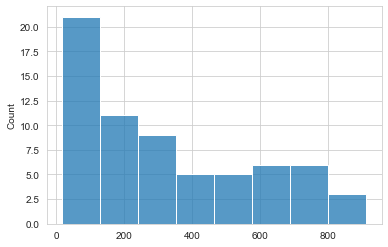

In [12]:
sns.set_style('whitegrid')
sns.histplot(num)